In [106]:
import pandas as pd
import numpy as np
import scipy
from scipy import ndimage

import os, errno

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


# define the width and length arrays 

rect_spc_x=0.001;
rect_spc_y=0.001;

rect_array_x = np.zeros(54)
rect_array_y = np.zeros(54)

for ix in range(54):
    rect_array_x[ix]=(rect_spc_x*(ix+1))/2

for iy in range(54):
    rect_array_y[iy]=(rect_spc_y*(iy+1))/2


In [107]:


def implt(image):
    plt.imshow(ndimage.rotate(image,90))
    plt.show()


def implt2(Y_train,Y_recovered,index):
    #gs = gridspec.GridSpec(1,2, height_ratios=[1,1])
    #fig = plt.figure()
    plt.figure(figsize=(12, 7))
    ax1 = plt.subplot(121)
    ax1.imshow(ndimage.rotate(Y_train[index,:].reshape(401,401),90))
    plt.title("Original", fontsize=16)

    ax2 = plt.subplot(122)
    ax2.imshow(ndimage.rotate(Y_recovered[index,:].reshape(401,401),90))
    plt.title("Compressed", fontsize=16)

    plt.show()

def implt3(Y_train,Y_recovered,idx,idy):
    #gs = gridspec.GridSpec(1,2, height_ratios=[1,1])
    #fig = plt.figure()
    index=dfX.index[(dfX['x (mm)'] == idx) & (dfX['y (mm)'] == idy)]
    plt.figure(figsize=(8, 5))
    ax1 = plt.subplot(121)
    ax1.imshow(ndimage.rotate(Y_train[index,:].reshape(401,401),90))
    plt.title("Original", fontsize=16)

    ax2 = plt.subplot(122)
    ax2.imshow(ndimage.rotate(Y_recovered.reshape(401,401),90))
    plt.title("Predicted", fontsize=16)
     
    plt.show()

In [17]:

# load, slice, and reshape 2D image into to 1D array 
import sys
sys.path.append('/home/j2/home/j2/ml/env/lib/python3.5/site-packages')
from numpy import unravel_index

feature_star = 0 
feature_end = 3 # not inclusive

import cv2
import argparse

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import ShuffleSplit


flag_plot_gene = 2
xlennum=42
ylennum=42

xrange = range(2,xlennum+1,4)
yrange = range(2,ylennum+1,4)
rect_ixx = np.zeros(len(xrange))
rect_iyy = np.zeros(len(yrange))


#image3D = []

clfscorelist = np.zeros(1)
cvscorelist = np.zeros(1)

#tholdmatrix = [0.02]
#tholdmatrix = [0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.98]
#tholdmatrix = [0.02,0.05,0.1,0.2,0.3,0.4]
#tholdmatrix = [0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,0.05]
# tholdmatrix = [0.015]
thold = 0.015
Maxvalue = 0.16565054

cvscoremeanlist = np.zeros(1)

In [113]:

totalIndex = 0 
directory = '/home/j2/Desktop/PythonTry/MLshm/oput/Matrix3Dthold%04d' % (thold*100)

try:
    os.makedirs(directory)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

nnum = 401 

kernelx = 15
kernely = 15
kernaltotal = kernelx * kernely

kernel = np.ones((kernelx,kernely),np.float32)/kernaltotal

df = pd.read_csv('sumValuesThrhPer20.csv')
dfXtemp = df[['x (mm)','y (mm)']]

X = np.zeros((1,2))
Y = np.zeros((1,6))

image3D = np.zeros((401,401))
image2DLong = np.zeros(((401*401),1))


for ixx in xrange: #range(2,10+1,4):#
    for iyy in yrange: # range(2,6+1,4):#
        rect_ixx = rect_array_x[ixx]
        rect_iyy = rect_array_y[iyy]

        totalIndex += 1 
        Dxmm = int(round(2*rect_ixx*1e3-1))    
        Dymm = int(round(2*rect_iyy*1e3-1))

        parafilename = '/home/j2/Desktop/PythonTry/MLshm/MLRTMwithExperiment/rectx%03dy%03d/iter00000/bnzlcc.csv' % (Dxmm,Dymm)
        tempdf = pd.read_csv(parafilename,header=None)


        tempdfabs = abs(tempdf.values)
        filter_abs = cv2.filter2D(tempdfabs,-1,kernel)
        filter_abs_temp = filter_abs
        maxfilter_abs = filter_abs.max().max()
        filter_abs_temp[filter_abs < thold*(Maxvalue)] = 0
        filter_abs_temp[:,:130] = 0
        
        
        
        image3D = np.dstack((image3D, filter_abs_temp)) 

        if flag_plot_gene == 1: 
            imagfilename = '/home/j2/Desktop/PythonTry/MLshm/oput/feature_star%dthold%03d/filter%d.png' % (feature_star,(thold*100),totalIndex)
            fig = plt.figure()
            plt.imshow(ndimage.rotate(filter_abs_temp,90))

            plt.title('Dx = %d mm   Dy= %d mm' % (Dxmm,Dymm))
            plt.savefig(imagfilename,format='png', dpi=300)
            #plt.show()
            plt.close()

        LL = np.zeros([nnum,nnum])
        #LL[filter_abs > thold*maxfilter_abs] = 1
        LL[filter_abs > thold*(Maxvalue)] = 1

        P_area_num=LL.sum().sum()
        P_width = np.sum(LL,axis=0).max()
        P_length = np.sum(LL,axis=1).max()
        Pxy = unravel_index(filter_abs_temp.argmax(), filter_abs_temp.shape)  
        onerow = np.array([P_area_num,P_width,P_length,Pxy[0],Pxy[1],maxfilter_abs]).reshape((1,6))
        onerowX = np.array([Dxmm,Dymm]).reshape((1,2))
        X = np.append(X,onerowX,axis=0)
        Y = np.append(Y,onerow,axis=0)

Yfinal = Y[1:,:]
Xfinal = X[1:,:]
X = Xfinal
Y = Yfinal
imagefinal3D = image3D[:,:,1:]
imagefinal2DLong = np.transpose(imagefinal3D.reshape(160801,121))
 

file_nametxt ='iput/matrix2DLong%04d.txt' % (thold*1000)
file_nametxtx ='iput/mx%04d.txt' % (thold*1000)
file_nametxty ='iput/my%04d.txt' % (thold*1000)

with open(file_nametxt,'wb') as f:
    np.savetxt(file_nametxt,imagefinal2DLong)
with open(file_nametxtx,'wb') as f:
    np.savetxt(file_nametxtx,X)
with open(file_nametxty,'wb') as f:
    np.savetxt(file_nametxty,Y)
 


In [112]:
imagefinal2DLong2 = np.loadtxt(file_nametxt)

implt(imagefinal2DLong2[50,:].reshape(401,401))


/home/j2/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: loadtxt: Empty input file: "iput/matrix2DLong0015.txt"
  """Entry point for launching an IPython kernel.


IndexError: too many indices for array

In [110]:
# select the first three attributes of the thresholded image: area, width, length 
Y3 = Y[:,feature_star:feature_end]


In [55]:
from sklearn import linear_model

rs_end = 42
cvscoremeanlist = np.zeros(1)
for random_statevalue in range(rs_end): 
    print('random state = ', random_statevalue)
    X_train, X_test, Y3_train, Y3_test = train_test_split(X, Y3, test_size=0.02, random_state=random_statevalue)

    
    # ordinary least squares
    clf = linear_model.LinearRegression()
    # univariate
    clf.fit(X_train,Y3_train)
    clf.score(X_test, Y3_test) 


    def NNpredcheck(x,y,model):
        Yt1 = model.predict(np.array([[x, y]]))
        return Yt1

    textclfscore = ' clf score : ' + np.array_str(clf.score(X_test, Y3_test)) + '\n'
    clfscorestr = np.array_str(clf.score(X_test, Y3_test)) + '\n'
    text35 = 'output (3 5): ' + np.array_str(NNpredcheck(3,5,clf)) + '\n'
    headline = 'feature_star %d thold %d percent  \n' % (feature_star,thold*100)
    #NNpredcheck(3,5,clf)

    outputfilename ='oput/NN3parafeature_star%dthold%03d.csv' % (feature_star,thold*100)

    with open(outputfilename, "w") as f:
        f.write(headline)
        f.write(textclfscore)
        f.write(clfscorestr)
        f.write(text35)


    #indexnumber = 1
    f= open(outputfilename,"a+")
    for irad in range(2):
        indexnumber = irad
        #print('index number is =', indexnumber)
        str1 =  'width and length = ' + np.array_str(X_test[indexnumber,:].reshape(1,-1)) +'\n'
        f.write(str1)
        print('width and length = ', X_test[indexnumber,:].reshape(1,-1) )
        str1 =  'predicted = ' + np.array_str(clf.predict(X_test[indexnumber,:].reshape(1,-1))) +'\n'
        f.write(str1)
        print('predicted = ', clf.predict(X_test[indexnumber,:].reshape(1,-1) ))
        str1 =  'labeled = ' + np.array_str(Y3_test[indexnumber,:]) +'\n'
        f.write(str1)
        print('labeled = ', Y3_test[indexnumber,:])
        str1 = 'Ratio = ' + np.array_str(clf.predict(X_test[indexnumber,:].reshape(1,-1) )/Y3_test[indexnumber,:]) + '\n'
        f.write(str1)
        print('Ratio = ', clf.predict(X_test[indexnumber,:].reshape(1,-1) )/Y3_test[indexnumber,:]) 

    f.close()

    print(textclfscore)
    cv = ShuffleSplit(n_splits=121, test_size=0.02, random_state=random_statevalue)
    cvscores = cross_val_score(clf, X, Y3, cv=cv)
    #cvscores = cross_val_score(clf, X, Y3, cv=60)
    print('CV score are', cvscores)
    print('Mean of cv_scores are', cvscores.mean())

    clfscorelist = np.append(clfscorelist,clf.score(X_test, Y3_test)) 
    cvscorelist = np.append(cvscorelist,cvscores.mean()) 

    cvscoremeanlist = np.append(cvscoremeanlist,cvscores.mean()) 

cvscoremeanlistFinal = cvscoremeanlist[1:]

cvscoremeandict = pd.Series(cvscoremeanlistFinal,index=np.arange(0,42,1))

    
    

random state =  0
width and length =  [[ 18.  18.]]
predicted =  [[ 3804.27350948    73.83476977    69.0211267 ]]
labeled =  [ 3805.    75.    75.]
Ratio =  [[ 0.99980907  0.9844636   0.92028169]]
width and length =  [[ 34.  26.]]
predicted =  [[ 5931.63909757    93.28607324    85.49179385]]
labeled =  [ 6071.    91.    87.]
Ratio =  [[ 0.97704482  1.02512168  0.9826643 ]]
 clf score : 0.9926907209647555

CV score are [  9.92690721e-01   9.76456037e-01   6.35899624e-01   9.91898114e-01
   9.34357887e-01   7.54227232e-01   9.84053719e-01   9.28723233e-01
   6.63495044e-01   8.47050309e-01   8.71852339e-01   6.62864860e-01
   8.35913256e-01   9.19798743e-01   8.55252456e-01   9.58776460e-01
   7.92445822e-01   8.95436819e-01   9.50058250e-01   9.64773251e-01
   8.44806543e-01   9.85924894e-01   9.88411611e-01   6.69581058e-01
   9.24762924e-01   7.80769110e-01   8.37161578e-01   9.74652200e-01
   7.52866204e-01   5.97426158e-01   9.23532553e-01   9.82024742e-01
   3.83969027e-01   2.9503

CV score are [  0.80230153   0.93136386   0.92149083   0.9873172    0.79321925
   0.86091387  -1.68850004   0.66792646   0.75004335   0.9887258
  -1.96647115   0.79532921 -37.52145591   0.92155154  -0.21016224
   0.41599859   0.9329828    0.9120237    0.48291287   0.08287393
   0.80478547   0.6445434   -2.0330805    0.92495187   0.84623514
   0.9622599    0.89702808   0.98843948   0.93061541  -0.98369199
   0.99484924   0.98220276   0.58940177  -1.15389319   0.92785153
   0.66781541   0.88937088   0.91981009   0.9523474    0.9956046
   0.6251671    0.97407299   0.75044188 -37.12509093   0.96999586
   0.98638605   0.97897395   0.93454883   0.45633185   0.88366732
   0.96445007   0.92718947  -0.15919377   0.94283406   0.75871893
   0.9750849    0.86595954   0.71535575   0.10902548   0.79415126
   0.53772625   0.94257416  -0.94408901   0.55181243   0.92643637
   0.97897065   0.2515901    0.96797831   0.57483452   0.98685131
   0.93113625   0.94799569   0.99232103   0.74088543   0.95913471

CV score are [  0.98496951   0.88680773   0.9034851    0.98033      0.76535865
   0.93498333   0.97478948   0.97704853   0.89248159   0.99236081
   0.99110507   0.85047247   0.96214471   0.85528425   0.72007793
   0.54736895   0.86719273  -5.10352135   0.84515882   0.8728315
   0.93237937   0.89482663   0.91895334   0.73112845   0.9717627
  -0.33523465   0.83588805   0.5689191    0.97803874   0.85208781
   0.88898013   0.94065112   0.14992683   0.96104521   0.8751303
  -4.26057394   0.34626289   0.97737188   0.28871117   0.95875468
   0.77236245   0.75325384   0.96960086   0.90412767   0.74464685
   0.66018488   0.92640966   0.98185255   0.42929113   0.83466246
   0.92198597   0.95739773   0.8842392    0.86346533   0.16152589
   0.98887204   0.98032924   0.99025169   0.39266368   0.9262397
   0.91218944   0.89602749  -0.16612422   0.94441252   0.47740104
  -0.38600482   0.80355261   0.96012932   0.79771939   0.98688513
   0.69919334   0.44710815   0.97833043   0.95679262   0.78130792
 

predicted =  [[ 4161.01792854    94.33971039    54.55213827]]
labeled =  [ 3689.    91.    51.]
Ratio =  [[ 1.12795281  1.03670011  1.06964977]]
 clf score : 0.2583248287640945

CV score are [  0.25832483   0.87427385   0.78571559   0.93769359   0.22656707
   0.85205075   0.99791817  -0.23715224   0.79137956  -2.17696626
   0.98188908   0.99090684   0.60150986   0.62451726   0.44124907
   0.79338177   0.85675161   0.95127071   0.83809183   0.63521167
   0.85121126   0.97356266   0.66152154  -1.84626457   0.85754631
  -0.38702541   0.9584447    0.87545646   0.70813357   0.96588081
 -12.11583692   0.93026776   0.98753029   0.97357913   0.72506904
   0.79944397   0.82815066   0.9738034   -0.20778325   0.96827913
   0.47519842   0.84117134  -0.3050068    0.93216397  -0.35678149
   0.731204     0.96778245   0.98662197   0.86795448   0.5051074
   0.29442202   0.84481453   0.98238113   0.92463113   0.8756078
   0.96513827  -4.23758424   0.9839107    0.94163772   0.90911028
   0.94154438   0.9

CV score are [ 0.86171569  0.99022633  0.73619143  0.50378024  0.74982895  0.91305282
  0.88644442  0.88838711  0.87154818  0.93057549  0.9584447   0.7166929
  0.6673801   0.33194338  0.99278396  0.95401008  0.9584115   0.99090255
  0.84838987  0.89697787  0.98017038  0.886515    0.72504469  0.99068989
  0.94922387  0.99044613  0.98046427  0.98027676  0.9433631   0.68586621
  0.95646102  0.16604629  0.97198549  0.87766235  0.63907063  0.37813239
  0.61258811  0.98072163  0.96956225 -1.63765212  0.94935207  0.39537297
  0.64466464  0.96753695  0.94743447  0.39150434  0.4098493   0.71533629
  0.7412481   0.81537143  0.96415914  0.12909265  0.98793541  0.42214642
  0.84553377  0.98855699  0.97362899  0.65010732  0.64590566  0.97832522
  0.76262892  0.95566137  0.99081794  0.95693695  0.93936482  0.92032433
  0.78889137  0.90880544  0.79225044  0.88065568  0.96598729  0.96989325
  0.97874409  0.9119398   0.30029298 -0.16961183  0.99203309  0.97265907
  0.90777951  0.84322421  0.98725497  0

CV score are [  0.87855307   0.86004386   0.76948973   0.88948027   0.96340969
   0.97725425   0.95276319   0.88687429   0.89019088   0.98338306
   0.91779282  -0.18983717   0.94742798   0.97507007   0.98878877
  -0.10635777   0.98375048   0.55543283   0.89792769   0.98464227
   0.85719689   0.81758128   0.9375583    0.83058078   0.98852447
   0.80774939   0.99438791   0.64069765   0.95541432   0.93160024
   0.98665449   0.78469753   0.36829794   0.98996322   0.92780593
   0.9267392    0.88943631   0.9924175    0.95544394   0.99398499
   0.87664286   0.96019393   0.58903377   0.73942926   0.74206728
   0.83804087   0.69368075   0.67109624   0.85357173   0.9382517
   0.80252146   0.82364158   0.97633378   0.69401512   0.9679384
   0.87051301   0.96084898   0.87484358   0.96086246   0.94232062
   0.58264604   0.98074341  -2.34825779   0.98226439   0.83328721
   0.9650248   -0.08304048   0.71117654   0.74262806   0.9743865
   0.94771634   0.74222831   0.6466818    0.98370914   0.99177167


CV score are [ 0.75754065  0.73226084  0.96505001  0.86493692 -8.72530238  0.9542873
  0.22636374 -1.13239887  0.98067094  0.98390417  0.81540794  0.67422049
  0.98391738  0.87253209  0.42325844  0.95599487  0.97685295  0.87794068
  0.98768293  0.98639825  0.98452757  0.94118197  0.20324883  0.94287732
  0.24908908  0.72733014 -0.64133001 -0.49278479  0.96152972  0.87668055
  0.90972463  0.9074364   0.99151274  0.86062734  0.77721862  0.98287168
  0.92424171 -0.70224464  0.99360459  0.95223867  0.04814394 -0.25031595
  0.73733051  0.72079201  0.87056665  0.91987729  0.94973092  0.93815321
  0.85579105  0.80663225  0.9937687   0.62430726  0.98572687  0.46138783
  0.97946929  0.78766808  0.92565547  0.97011052  0.80460458  0.82886248
  0.24260915  0.72124327  0.99093562  0.99690748  0.97884475  0.95504135
  0.76587294  0.97625255  0.5686087   0.9608651   0.95960493  0.96956502
  0.94336191 -4.02889615 -2.11759912  0.84505403  0.98075313  0.91478921
  0.95619173  0.96886142  0.96773166  0

CV score are [ 0.93927307  0.89980053  0.98411561  0.92015365  0.79293996  0.89937098
  0.46824422  0.99090434  0.96372932  0.96076414  0.7935597   0.71244639
  0.84821602  0.42016363  0.54040041  0.75960283  0.98724933  0.64383487
  0.95968083 -3.63658896  0.99135372  0.90397519  0.93427128  0.86703237
  0.97932601  0.82443688  0.98208301  0.45847884  0.9910936   0.9599672
  0.64227061  0.97319305  0.49295818  0.29188977  0.97863153  0.41820258
  0.97795054  0.94774804  0.71112409  0.81222907  0.94214804 -1.86528381
 -1.07824584  0.93128211  0.98003474  0.61901503  0.97554129  0.82401658
  0.85824486  0.80991183  0.93116056  0.96975312 -0.69380999  0.96620942
  0.86035767  0.73726874  0.71405307  0.46485313  0.97798224  0.94345644
 -0.22479839  0.9356333   0.99345843  0.96689552  0.55797732  0.898415
  0.52200768  0.97733386  0.84095748 -1.72222175  0.70811144  0.9860045
  0.71691767  0.9086685   0.94549192  0.87126496  0.40481131  0.70264789
  0.93990863  0.94151749  0.92890244  0.98

CV score are [ 0.98994011  0.97608151  0.9067486   0.76183304  0.86351665  0.19061374
  0.27121904  0.60410276  0.89459283  0.97747067  0.87060513  0.97716167
  0.94357819  0.96139582  0.94989421  0.97810231  0.75041443  0.99790759
  0.90034353  0.97146955  0.92824836  0.89402047 -0.43638965  0.89739677
  0.96785566  0.94940903  0.83804087  0.91262512  0.96949604 -2.18223588
  0.95829294  0.8973875   0.92647115  0.75478594  0.9745037   0.98628406
  0.97764067  0.52692754  0.97494959 -0.89734826 -0.35492139  0.98236479
  0.94414902  0.91169855  0.9654274   0.98078754  0.4244157  -0.27806426
  0.99153374  0.98427635  0.96323642  0.92668793  0.9787035  -0.27133726
  0.95240239  0.94097609  0.61150895  0.92463051  0.95608348  0.84685641
  0.83714544 -0.78255213  0.9549204   0.41770093  0.29081102  0.9550174
  0.37695741  0.89468951  0.86287867  0.99780409  0.24667259  0.99975661
  0.20325584  0.65761886  0.60158699  0.96101602  0.79836234 -0.06474534
  0.97663238  0.86007918 -0.17647828  0

CV score are [  9.67032261e-01   9.62456234e-01   9.46089235e-01   5.41990610e-01
   9.83224129e-01   9.87202738e-01  -1.62534454e-01   9.54862706e-01
   7.65433524e-01   8.60488448e-01  -6.65596002e-01   9.88862620e-01
   8.57984762e-01   9.78736543e-01   7.36853800e-01   9.48810441e-01
   9.70656499e-01   9.96193097e-01   9.88941820e-01   2.50354840e-02
   1.42334555e-01   9.96376437e-01   8.17198959e-01   7.41926694e-01
   9.12605898e-01   7.63656856e-01   9.18673274e-01  -2.84492588e-03
   9.27675650e-01   3.81235500e-01   5.44965149e-01   8.26694263e-01
   8.42351198e-01   8.73346695e-01   8.51713464e-01   9.93002096e-01
   9.18080673e-01   9.68083653e-01   9.05493038e-01   9.44045746e-01
   4.18876110e-01   8.64340666e-01   9.85559877e-01   4.60772638e-01
   9.59984197e-01  -5.66501696e+01   9.89379426e-01   9.44837834e-01
   9.82407520e-01   9.25706430e-01   9.27003427e-01  -2.77915122e+00
   1.68830793e-01   8.58071798e-01   9.75478005e-01   9.15053812e-01
   9.90419333e-01   9

In [54]:
cvscoremeanlistFinal.shape

(170,)

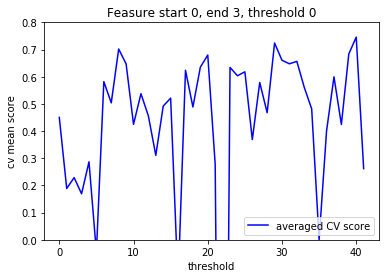

In [67]:


imagfilename = '/home/j2/Desktop/PythonTry/MLshm/oput/RSforthold%d.png' % (thold*1000)

fig = plt.figure()
plt.plot(cvscoremeandict, 'b-')
plt.ylim([0, 0.8])
#plt.plot(cvscoredict, 'r-')
plt.title('Feasure start %d, end %d, threshold %d' % (feature_star,feature_end, thold))
plt.xlabel('threshold')
plt.ylabel('cv mean score')

plt.savefig(imagfilename,format='png', dpi=300)
plt.legend(['averaged CV score'], loc=4) # 
plt.show()
plt.close()